In [1]:
# in this notebook, I'm attempting to track down the error in the adaptive timestep.
# why is it creating such a tiny timestep?

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP (scaled down) GRID ARRAYS
dx = 1
x = np.arange(0, 10, dx)

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:5] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[5:] = 0.000064

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:5] = 0.0001
k_sed = np.zeros(len(x))
k_sed[5:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    #dt = 0.2 * dx * dx / (c*q[-1])  # time-step size
    dt_global = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        
        print('Time:', cum_time)

        # Calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        #ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        #ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        # atr = beta_ig[1:] * qs[1:]
        atr = 0.000004 * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        #total_ero = bedrock_ero + sedimentation_rate
        total_ero[-1] = bedrock_ero[-1] - sedimentation_rate[-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        #if np.min(times_to_flat) <= np.min(times_to_no_sed):
        #    dt = 0.2 * np.min(times_to_flat)
        #else:
        #    dt = 0.2 * np.min(times_to_no_sed)
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt

        print("slope: ", S, "\n")
        print("sed flux: ", qs, "\n")
        print("efac: ", efac, "\n")
        print("topography: ", eta, "\n")
        print("bedrock: ", etab, "\n")
        print("igneous plucking rate: ", ero_plucking_ig, "\n")
        print("sedimentary plucking rate: ", ero_plucking_sed, "\n")
        print("igneous abrasion rate: ", ero_ab_ig, "\n")
        print("sedimentary abrasion rate: ", ero_ab_sed, "\n")
        print("bedrock erosion rate: ", bedrock_ero, "\n")
        print("attrition: ", atr, "\n")
        print("sedimentation rate: ", sedimentation_rate, "\n")
        print("sediment thickness: ", H, "\n")
        print("total erosion rate: ", total_ero, "\n")
        print("elevaion differences: ", elev_diff, "\n")
        print("erosion rate differences: ", ero_diff, "\n")
        print("location of negative erosion rates: ", valid_places, "\n")
        print("times to flat: ", times_to_flat, "\n")
        print("times to no sed: ", times_to_no_sed, "\n")
        print("timestep: ", dt, "\n")
        
    return (S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, elev_diff, ero_diff, valid_places, times_to_flat, 
            times_to_no_sed, dt)

In [5]:
(S, 
qs, 
efac, 
eta, 
etab, 
ero_plucking_ig, 
ero_plucking_sed,
ero_ab_ig,
ero_ab_sed,
bedrock_ero, 
atr, 
sedimentation_rate, 
H, 
total_ero,
elev_diff, 
ero_diff, 
valid_places, 
times_to_flat,
times_to_no_sed,
dt) = two_lith_one_sed(x,
                       dx,
                       Hstar,
                       H,
                       etab,
                       eta,
                       beta_ig,
                       beta_sed,
                       k_ig,
                       k_sed,
                       num_steps = 12)

Time: 0.0
slope:  [-0. -0. -0. -0. -0. -0. -0. -0. -0.] 

sed flux:  [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0.] 

efac:  [0.36787944 0.36787944 0.36787944 0.36787944 0.36787944 0.36787944
 0.36787944 0.36787944 0.36787944 1.        ] 

topography:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.22222222e-05] 

bedrock:  [-1.00000000e-01 -1.00000000e-01 -1.00000000e-01 -1.00000000e-01
 -1.00000000e-01 -1.00000000e-01 -1.00000000e-01 -1.00000000e-01
 -1.00000000e-01 -2.22222222e-05] 

igneous plucking rate:  [-0. -0. -0. -0. -0. -0. -0. -0. -0.] 

sedimentary plucking rate:  [-0. -0. -0. -0. -0. -0. -0. -0. -0.] 

igneous abrasion rate:  [-0. -0. -0. -0. -0. -0. -0. -0. -0.] 

sedimentary abrasion rate:  [-0. -0. -0. -0. -0. -0. -0. -0. -0.] 

bedrock erosion rate:  [-0. -0. -0. -0. -0. -0. -0. -0. -0.  0.] 

attrition:  [-0. -0. -0. -0. -0. -0. -0. -0. -0.] 

sedimentation rate:  [-0. -

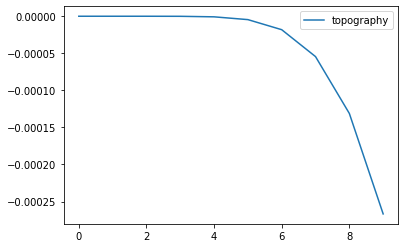

In [6]:
plt.plot(x, eta, label = 'topography')
# plt.plot(x, etab, label = 'bedrock')
# plt.plot(x, H, label = 'sediment')
plt.legend()

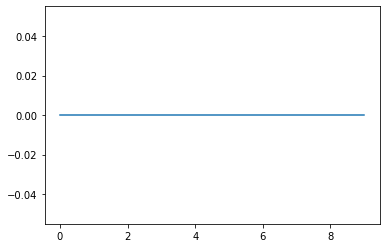

In [7]:
plt.plot(x, total_ero)